In [46]:
import splitfolders

In [47]:
input_folder="../input/spanish-sign-language-alphabet-static/fondo_blanco"

In [48]:
splitfolders.ratio(input_folder,output="new_input",seed=42,ratio=(.7,.2,.1),group_prefix=None)

Copying files: 1998 files [01:07, 29.66 files/s]


In [49]:
import os;
for dirpath,dirname,filename in os.walk("./new_input"):
    print(f"there are {len(dirname)} directories and {len(filename)} images in {dirpath}")

there are 3 directories and 0 images in ./new_input
there are 19 directories and 0 images in ./new_input/val
there are 0 directories and 21 images in ./new_input/val/K
there are 0 directories and 19 images in ./new_input/val/C
there are 0 directories and 20 images in ./new_input/val/T
there are 0 directories and 22 images in ./new_input/val/L
there are 0 directories and 20 images in ./new_input/val/S
there are 0 directories and 22 images in ./new_input/val/M
there are 0 directories and 20 images in ./new_input/val/A
there are 0 directories and 18 images in ./new_input/val/R
there are 0 directories and 21 images in ./new_input/val/G
there are 0 directories and 20 images in ./new_input/val/D
there are 0 directories and 21 images in ./new_input/val/U
there are 0 directories and 21 images in ./new_input/val/F
there are 0 directories and 19 images in ./new_input/val/O
there are 0 directories and 22 images in ./new_input/val/N
there are 0 directories and 20 images in ./new_input/val/E
there 

In [50]:
import numpy as np;
import pandas as pd;
import tensorflow as tf;
import matplotlib.pyplot as plt;
import matplotlib.image as mpimg;
import random;

In [51]:
import pathlib;
data_dir=pathlib.Path("./new_input/train")
class_names=np.array(sorted(item.name for item in data_dir.glob("*")))
class_names

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'I', 'K', 'L', 'M', 'N', 'O',
       'P', 'Q', 'R', 'S', 'T', 'U'], dtype='<U1')

In [52]:
def view_random_image(target_dir,target_class):
    target_folder=target_dir+target_class
    random_image=random.sample(os.listdir(target_folder),1)
    img=mpimg.imread(target_folder+"/"+random_image[0])
    plt.imshow(img)
    plt.axis(False)
    plt.title(target_class)
    print(f"the shape of the image is {img.shape}")
    return img
          

the shape of the image is (2408, 4288, 3)


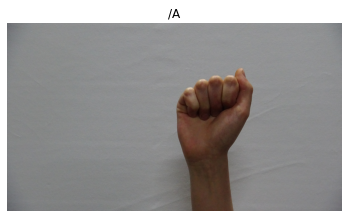

In [53]:
random_image=view_random_image("./new_input/train/","A")

the shape of the image is (2408, 4288, 3)


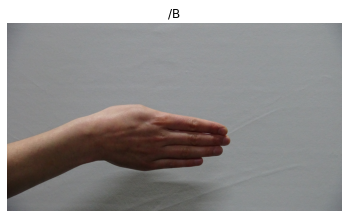

In [54]:
random_image2=view_random_image("./new_input/train","/B")

the shape of the image is (2408, 4288, 3)


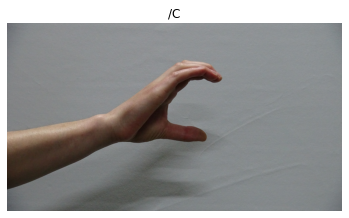

In [55]:
random_image3=view_random_image("./new_input/train","/C")

the shape of the image is (2408, 4288, 3)


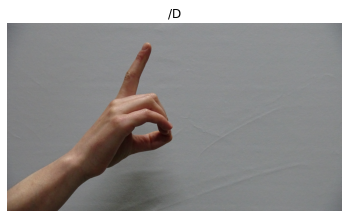

In [56]:
random_image4=view_random_image("./new_input/train","/D")

the shape of the image is (2408, 4288, 3)


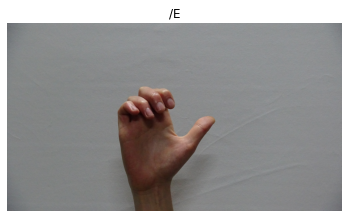

In [57]:
random_image5=view_random_image("./new_input/train","/E")

In [58]:
from keras.preprocessing.image import ImageDataGenerator;
train_datagen=ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,height_shift_range=0.2,width_shift_range=0.2,rotation_range=0.2,horizontal_flip=True)
test_datagen=ImageDataGenerator(rescale=1./255)
valid_datagen=ImageDataGenerator(rescale=1./255)
train_dir="./new_input/train"
test_dir="./new_input/test"
val_dir="./new_input/val"
train_data=train_datagen.flow_from_directory(directory=train_dir,target_size=(224,224),class_mode="categorical",batch_size=32,seed=42)
test_data=test_datagen.flow_from_directory(directory=test_dir,target_size=(224,224),class_mode="categorical",batch_size=32)
valid_data=valid_datagen.flow_from_directory(directory=val_dir,target_size=(224,224),class_mode="categorical")

Found 1390 images belonging to 19 classes.
Found 215 images belonging to 19 classes.
Found 393 images belonging to 19 classes.


In [59]:
from keras import layers;

In [60]:
!nvidia-smi -L


GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-3322ea25-9e1a-431a-c188-88a8a7d4881a)


In [61]:
base_model=tf.keras.applications.InceptionResNetV2(include_top=False,weights="imagenet",input_shape=(224,224,3))
base_model.trainable=False
model_2=tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256,activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(128,activation="relu"),
    layers.Dense(len(class_names),activation="softmax")
])
model_2.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

In [62]:
model_2.fit(train_data,epochs=5,steps_per_epoch=int(0.6*len(train_data)),validation_data=valid_data,verbose=1)

Epoch 1/5
26/26 [==============================] - 216s 8s/step - loss: 2.7170 - accuracy: 0.1892 - val_loss: 1.8894 - val_accuracy: 0.5471
Epoch 2/5
26/26 [==============================] - 196s 8s/step - loss: 1.8677 - accuracy: 0.4115 - val_loss: 1.1554 - val_accuracy: 0.7125
Epoch 3/5
26/26 [==============================] - 191s 7s/step - loss: 1.4283 - accuracy: 0.5356 - val_loss: 0.8087 - val_accuracy: 0.7863
Epoch 4/5
26/26 [==============================] - 193s 7s/step - loss: 1.1301 - accuracy: 0.6286 - val_loss: 0.5468 - val_accuracy: 0.8779
Epoch 5/5
26/26 [==============================] - 190s 7s/step - loss: 0.8357 - accuracy: 0.7088 - val_loss: 0.4216 - val_accuracy: 0.8779


In [69]:
def load_and_prep(filename):
    img=tf.io.read_file(filename)
    img=tf.image.decode_image(img)
    img=tf.image.resize(img,size=[224,224])
    img=img/255.
    return img
def pred_and_plot(model,filename,class_name=class_names):
    img=load_and_prep(filename)
    pred=model.predict(tf.expand_dims(img,axis=0))
    if len(pred[0])>1:
        pred_class=class_name[tf.argmax(pred[0])]
    else :
        pred_class=class_name[int(tf.round(pred[0]))]
    plt.axis(False)
    plt.title(f"Prediction:{pred_class}")
    plt.imshow(img)
        

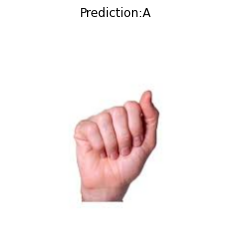

In [70]:
img=pred_and_plot(model_2,"../input/googleimages/A1.jpg")

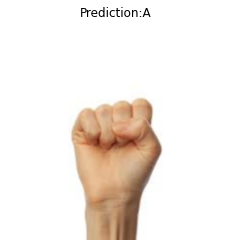

In [71]:
img1=pred_and_plot(model_2,"../input/googleimages/A.jpg")